<a href="https://colab.research.google.com/github/Gandharv29/Speaker_verification_system/blob/main/Speaker_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import soundfile as sf
import random

# Target speaker- 26
target_folder = "/content/drive/MyDrive/target speaker"


import librosa
import numpy as np
import os
import soundfile as sf
import random

# Define target speaker folder (augmented audios will be saved here)
target_folder = "/content/drive/MyDrive/target speaker"

# Get all target speaker files
target_files = [os.path.join(target_folder, f) for f in os.listdir(target_folder) if f.endswith(".wav")]

# Function for pitch shifting
def pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

# Function to add random noise
def add_noise(y, noise_level=0.005):
    return y + noise_level * np.random.randn(len(y))

# Function to randomly change volume
def change_volume(y, gain=1.2):
    return y * gain

# Function to shift audio
def shift_audio(y, shift_max=0.2, sr=16000):
    shift = int(random.uniform(-shift_max, shift_max) * sr)
    return np.roll(y, shift)

# Augment and save new audio files directly in target folder
for file in target_files:
    y, sr = librosa.load(file, sr=16000)  # Load audio

    # Apply augmentations
    augmented_versions = [
        ("pitch_shift", pitch_shift(y, sr, n_steps=random.randint(-2, 2))),
        ("add_noise", add_noise(y, noise_level=random.uniform(0.002, 0.01))),
        ("change_volume", change_volume(y, gain=random.uniform(0.8, 1.2))),
        ("shift_audio", shift_audio(y, shift_max=0.2, sr=sr)),
    ]

    # Save each augmented file in the target folder
    for aug_name, aug_audio in augmented_versions:
        new_file_name = f"{os.path.basename(file).replace('.wav', '')}_{aug_name}.wav"
        new_file_path = os.path.join(target_folder, new_file_name)
        sf.write(new_file_path, aug_audio, sr)

print(f"Augmentation Complete! Augmented files saved directly in {target_folder}")



In [46]:
# Define paths
non_target_folder = "/content/drive/MyDrive/otherSpeakers"

# Parameters
sample_rate = 16000
n_mels = 128  # Number of Mel bands
duration = 3  # Seconds (pad/truncate all audio to this length)
n_fft = 1024
hop_length = 512

# Function to convert audio to Mel Spectrogram
def extract_melspectrogram(file_path):
    y, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB
    return mel_spec

# Prepare dataset
data = []
labels = []

# Process target speaker files (label 1)
for file in os.listdir(target_folder):
    if file.endswith(".wav"):
        file_path = os.path.join(target_folder, file)
        features = extract_melspectrogram(file_path)
        data.append(features)
        labels.append(1)

# Process non-target speaker files (label 0)
for file in os.listdir(non_target_folder):
    if file.endswith(".wav"):
        file_path = os.path.join(non_target_folder, file)
        features = extract_melspectrogram(file_path)
        data.append(features)
        labels.append(0)

# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

# Reshape X for CNN input: (samples, height, width, channels)
X = X[..., np.newaxis]  # Adding a channel dimension

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")


Data shape: (1072, 128, 94, 1), Labels shape: (1072, 2)


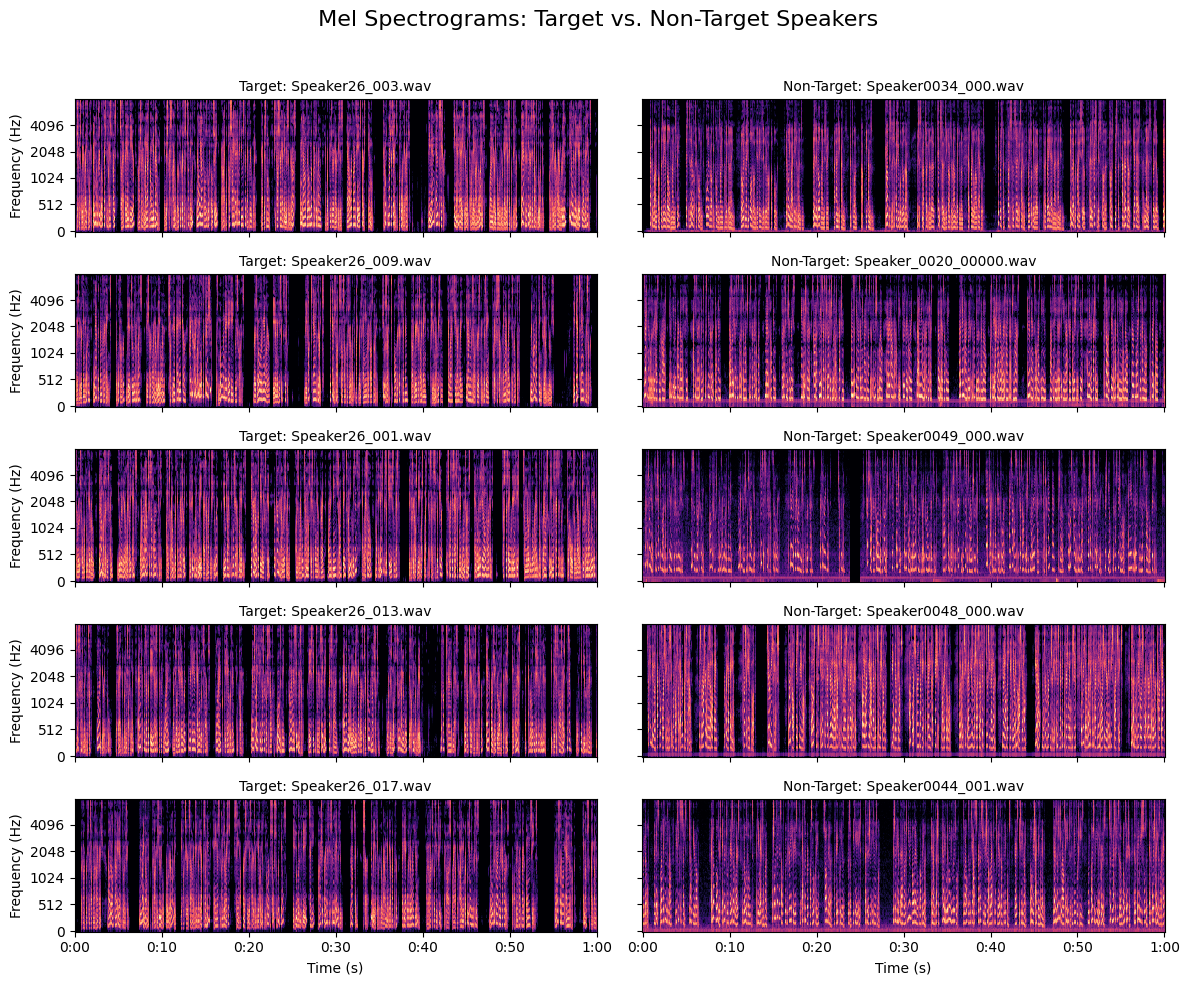

In [48]:
target_files = [os.path.join(target_folder, f) for f in os.listdir(target_folder) if f.endswith(".wav")][:5]
non_target_files = [os.path.join(non_target_folder, f) for f in os.listdir(non_target_folder) if f.endswith(".wav")][:5]

# Function to plot Mel spectrogram
def plot_mel_spectrogram(file_path, ax, title):
    y, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=1024, hop_length=512)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", ax=ax)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.label_outer()


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 10))
fig.suptitle(" Mel Spectrograms: Target vs. Non-Target Speakers", fontsize=16)


for i, file in enumerate(target_files):
    plot_mel_spectrogram(file, axes[i, 0], f"Target: {os.path.basename(file)}")


for i, file in enumerate(non_target_files):
    plot_mel_spectrogram(file, axes[i, 1], f"Non-Target: {os.path.basename(file)}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Output layer with 2 classes (target/non-target)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 450ms/step - accuracy: 0.7379 - loss: 10.2332 - val_accuracy: 0.8791 - val_loss: 0.4112
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - accuracy: 0.8617 - loss: 0.4698 - val_accuracy: 0.8791 - val_loss: 0.4807
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.8399 - loss: 0.4164 - val_accuracy: 0.8977 - val_loss: 0.2306
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.8796 - loss: 0.3076 - val_accuracy: 0.8791 - val_loss: 0.2704
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.8968 - loss: 0.2388 - val_accuracy: 0.9860 - val_loss: 0.1337
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 405ms/step - accuracy: 0.9603 - loss: 0.1193 - val_accuracy: 0.9907 - val_loss: 0.1494
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 506ms/step - accuracy: 0.9726 - loss: 0.1273 - val_accuracy: 0.9767 - val_loss: 0.0840
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 508ms/step - accuracy: 0.9640 - loss: 0.0810 - val_acc

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Get model predictions
y_pred_probs = model.predict(X_test)  # Get softmax probabilities
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step
Accuracy: 0.9860
Precision: 0.9844
Recall: 1.0000
F1-Score: 0.9921


In [52]:
def predict_speaker(file_path, model):
    features = extract_melspectrogram(file_path)  # Extract Mel Spectrogram
    features = features[np.newaxis, ..., np.newaxis]  # Reshape for CNN input

    prediction = model.predict(features)
    class_index = np.argmax(prediction)
    confidence = prediction[0][class_index]

    return "Target Speaker" if class_index == 1 else "Non-Target Speaker", confidence

# Test with a non target audio file
test_audio = "/test_Speaker0043_001.wav"
prediction, confidence = predict_speaker(test_audio, model)
print(f"Prediction: {prediction}, Confidence: {confidence:.2f}")
# testing with a target audio file
test_audio = "/Speaker26_006.wav"
prediction, confidence = predict_speaker(test_audio, model)
print(f"Prediction: {prediction}, Confidence: {confidence:.2f}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction: Non-Target Speaker, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Prediction: Target Speaker, Confidence: 1.00
